100%|██████████| 2/2 [00:44<00:00, 22.10s/it]


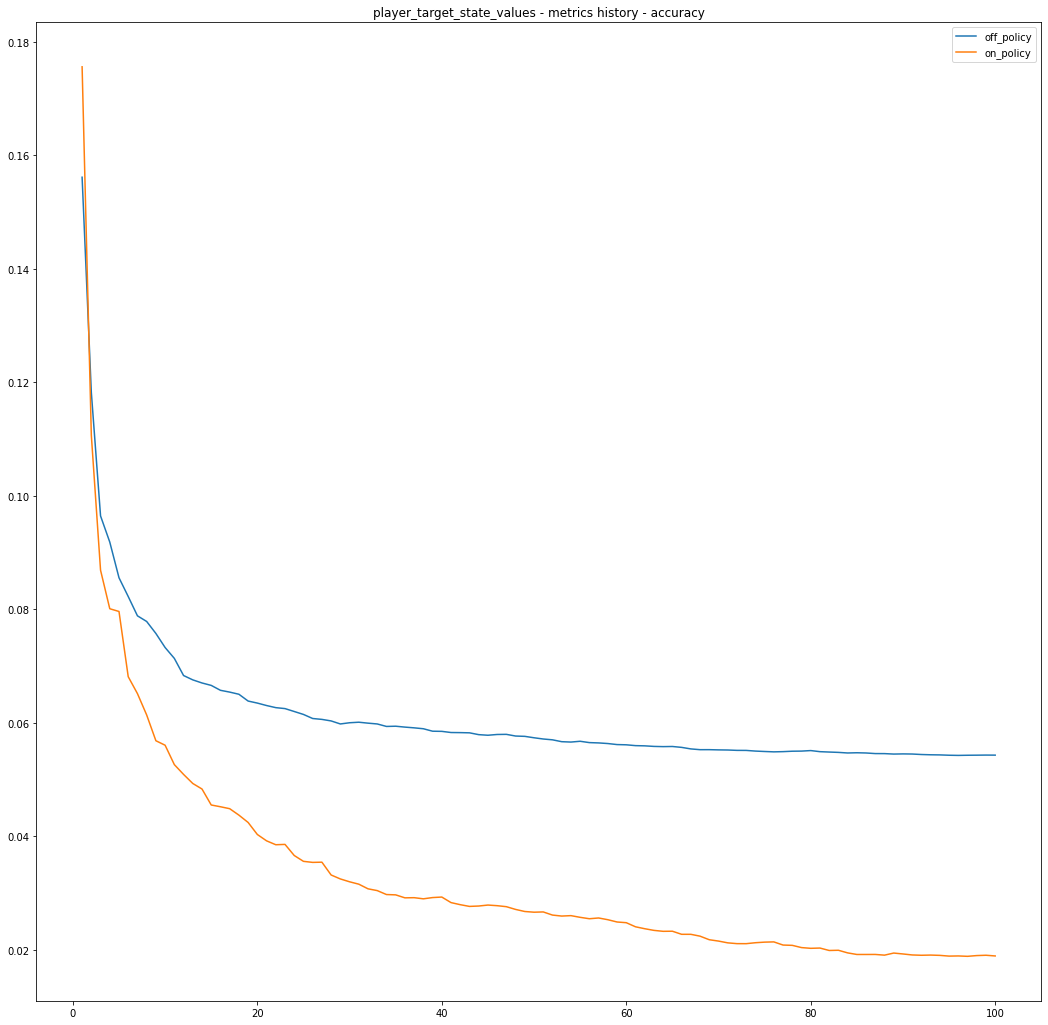

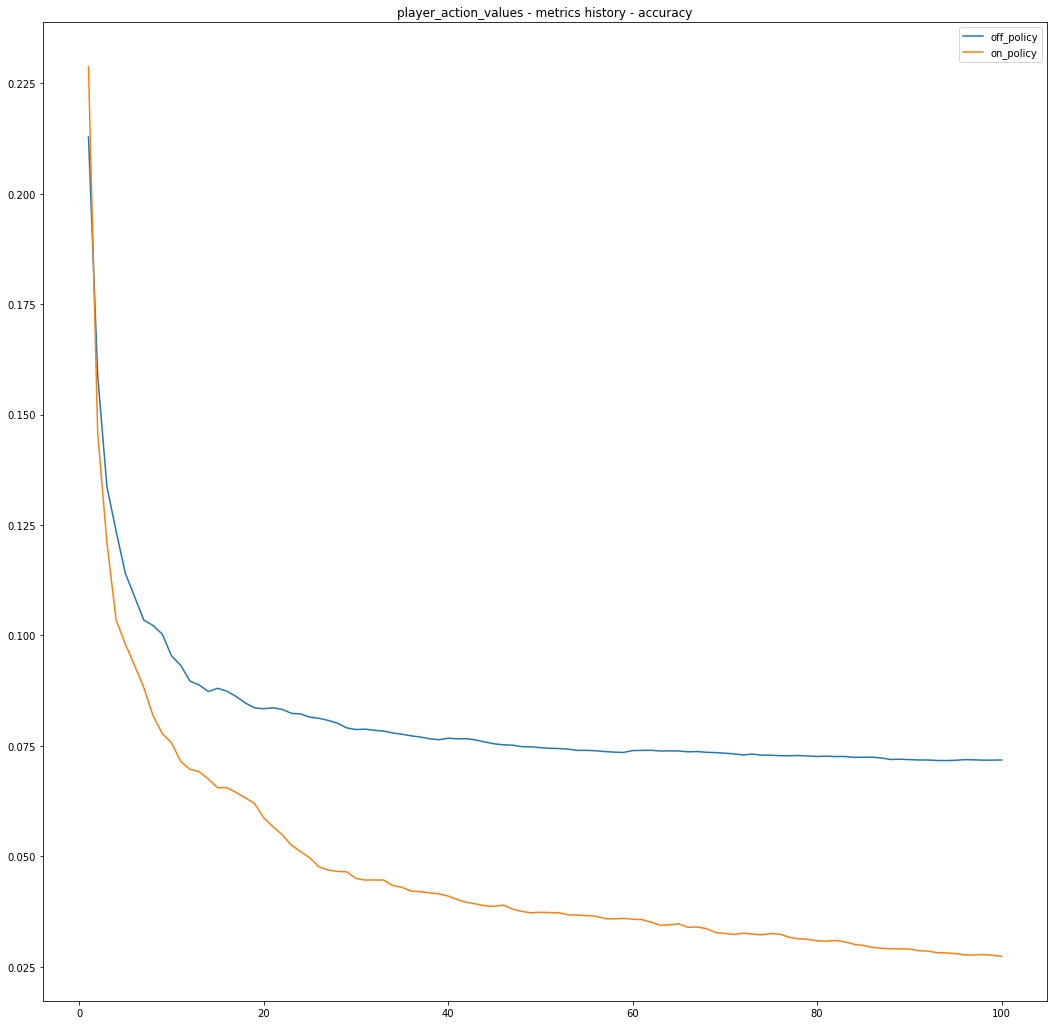

In [4]:
# TASK:
# - check TD(0) on/off-policy ~ (variance, convergence)
#
# PROCESS:
# - run the same BATCH*EPISODES for on/off-policy
# - td_lambda_forward, lambda_value=0
# - check target_state_value_store (accuracy_history, final_accuracy)
#
# RESULTS:
# - off_policy shows better accuracy when BATCH is small
#   but worse convergence accuracy when BATCH is large
# - on_policy shows the opposite, achieves better accuracy when
#   BATCH>10
#
# INTERPRETATION:
# - off_policy is quicker to converge but with bias
#   as it assumes the optimal action when BATCH is small
#   and update action value towards the optimal estimation,
#   it introduces bias making those assumptions that
#   can be either not likely to happen in actual samples
#   or to avoid new sampling information when BATCH is large
# - off_policy still achieves good accuracy
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import tqdm

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS

#
# hyperparameters and agent config
#

BATCH = 100
EPISODES = int(1e4)

PLAYER = ModelFreeAgent("player", ACTIONS)
PLAYER.load_optimal_state_values()
PLAYER.true_action_value_store.load("../output/player_true_action_values.json")

PLAYER.target_state_value_store.metrics.register(
    "accuracy",
    PLAYER.target_state_value_store_accuracy_to_optimal,
)
PLAYER.action_value_store.metrics.register(
    "accuracy",
    PLAYER.action_value_store_accuracy_to_true,
)

#
# process
#

off_policy_options = [True, False]

for off_policy in tqdm(off_policy_options):

    PLAYER.action_value_store.reset()

    for _ in range(BATCH):
        for _ in range(EPISODES):
            playout(
                player_policy=PLAYER.e_greedy_policy,
                player_offline_learning=lambda episode: PLAYER.forward_td_lambda_learning_offline(
                    episode,
                    off_policy=off_policy,
                ),
            )

        PLAYER.target_state_value_store.metrics.record("accuracy")
        PLAYER.action_value_store.metrics.record("accuracy")

    PLAYER.target_state_value_store.metrics.stack("accuracy")
    PLAYER.action_value_store.metrics.stack("accuracy")

labels = ["off_policy", "on_policy"]
PLAYER.target_state_value_store.metrics.plot_history_stack(
    "accuracy",
    labels=labels,
)
PLAYER.action_value_store.metrics.plot_history_stack(
    "accuracy",
    labels=labels,
)
